In [5]:
import pandas as pd
import numpy as np
import math
df=pd.read_csv(r"C:\Users\Ameya Bansal\OneDrive\Documents\Market Mood Moves&Sentiment Based Stock Prediction\AppleNewsStock.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,News
0,2006-12-01,13.114285,13.190000,12.871428,91.320000,13.045714,198769900,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...
1,2006-12-04,13.125714,13.150000,12.928572,91.120003,13.017143,177384200,More on Housing Prices : The broadest governme...
2,2006-12-05,13.092857,13.190000,12.981428,91.269997,13.038571,165709600,NaN
3,2006-12-06,12.948571,13.055715,12.810000,89.830002,12.832857,159546100,Honoring R.W. Apple in Words and Food : About ...
4,2006-12-07,12.861428,12.928572,12.414286,87.040001,12.434286,251206900,"Homebuilders, and Worries Over Jobs, Lead a De..."


In [176]:
df['Returns']=np.log(df['Close']/df['Close'].shift(1))
df['News'] = df['News'].fillna("No news available")
df=df.tail(1200)

In [177]:
from transformers import BertTokenizer

# Load the FinBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

def count_tokens(text):
    if pd.isna(text):
        return 0
    # encode() adds special tokens [CLS] and [SEP] automatically
    return len(tokenizer.encode(text, add_special_tokens=True))

# Assuming 'news' is your column name
df['token_count'] = df['News'].apply(count_tokens)

# Check how many rows exceed the limit
exceeds_limit = df[df['token_count'] > 512]
print(f"Rows exceeding 512 tokens: {len(exceeds_limit)}")
print(f"Maximum token count found: {df['token_count'].max()}")

Token indices sequence length is longer than the specified maximum sequence length for this model (945 > 512). Running this sequence through the model will result in indexing errors


Rows exceeding 512 tokens: 6
Maximum token count found: 955


In [178]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
def get_chunked_sentiment(text, tokenizer, model):
    # Tokenize the entire text without truncation to see the full length
    inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    input_ids = inputs['input_ids'][0]
    
    # Define chunk size (allowing space for [CLS] and [SEP] tokens)
    chunk_size = 510 
    chunks = [input_ids[i:i + chunk_size] for i in range(0, len(input_ids), chunk_size)]
    
    all_probabilities = []
    
    for chunk in chunks:
        # Add special tokens [CLS] and [SEP] back to each chunk
        chunk_with_special = torch.cat([torch.tensor([tokenizer.cls_token_id]), 
                                        chunk, 
                                        torch.tensor([tokenizer.sep_token_id])])
        
        # Run inference
        with torch.no_grad():
            outputs = model(chunk_with_special.unsqueeze(0))
            probs = F.softmax(outputs.logits, dim=1)
            all_probabilities.append(probs)
    
    # Average the probabilities across all chunks 
    avg_probs = torch.mean(torch.stack(all_probabilities), dim=0).squeeze().numpy()
    effective_sentiment = avg_probs[0] - avg_probs[1]
    return effective_sentiment
df['Sentiment Score']=df['News'].apply(lambda x: get_chunked_sentiment(x, tokenizer, model))
df.head(20)

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 461.92it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Token indices sequence length is longer than the specified maximum sequence length for this model (945 > 512). Running this sequence through the model will result in indexing errors


,Date,Open,High,Low,Close,Adj Close,Volume,News,Returns,token_count,Sentiment Score,RSI,MACD,MACD_Signal,Volatility
2097,2015-04-06,124.470001,127.510002,124.330002,127.349998,127.349998,37194000,Samsung Beats Analyst Predictions Despite Fall...,NaN,177,-0.014851,55.602242,-0.284662,-0.405883,0.014570
2098,2015-04-07,127.639999,128.119995,125.980003,126.010002,126.010002,35012300,No news available,-0.010578,5,-0.065423,47.508468,-0.224009,-0.369508,0.014734
2099,2015-04-08,125.849998,126.400002,124.970001,125.599998,125.599998,37329200,Dear Diary: My Week Wearing an Apple Watch : S...,-0.003259,386,0.531618,42.697194,-0.206642,-0.336935,0.013952
2100,2015-04-09,125.849998,126.580002,124.660004,126.559998,126.559998,32484000,"Ahead of Watch Release, Apple to Allow Custome...",0.007614,397,-0.048368,47.606920,-0.114100,-0.292368,0.013302
2101,2015-04-10,125.949997,127.209999,125.260002,127.099998,127.099998,40188000,Apple Watch on show : Apple stores in Asia giv...,0.004258,404,-0.023169,53.229268,0.002782,-0.233338,0.012767
2102,2015-04-13,128.369995,128.570007,126.610001,126.849998,126.849998,36365100,Time to up Apple Watch production : Apple is e...,-0.001969,379,0.033684,48.972600,0.074381,-0.171794,0.012651
2103,2015-04-14,127.000000,127.290001,125.910004,126.300003,126.300003,25524600,What We&#8217;re Reading : Get recommendations...,-0.004345,421,-0.275407,48.888892,0.085756,-0.120284,0.012499
2104,2015-04-15,126.410004,127.129997,126.010002,126.779999,126.779999,28970400,Google Joins Its U.S. Peers Under Europe’s Scr...,0.003793,469,-0.064046,61.548925,0.131980,-0.069831,0.011949
2105,2015-04-16,126.279999,127.099998,126.110001,126.169998,126.169998,28369000,Apple Watch Availability Is Clarified : Apple’...,-0.004823,389,0.014571,56.668973,0.118031,-0.032259,0.011686
2106,2015-04-17,125.550003,126.139999,124.459999,124.750000,124.750000,51957000,"Banking on Apple Watch Will Be Limited, for No...",-0.011318,379,-0.038202,55.033559,-0.007519,-0.027311,0.011828


In [179]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])
def calculate_macd(data, slow=26, fast=12, signal=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd,signal_line
df['MACD'],df['MACD_Signal'] = calculate_macd(df['Close'])
df['Volatility'] = df['Returns'].rolling(window=20).std()
df['Sentiment Score']=df['Sentiment Score'].shift(5)
df=df.dropna()

In [180]:
target_col = 'Returns'
other_features = ['Sentiment Score', 'RSI', 'MACD', 'Volatility', 'Volume']

train_length=int(0.8*len(df))
train_df=df[:train_length]
test_df=df[train_length:]
# 2. Training Data Statistics
# For Returns (Standardization)
train_ret_mean = train_df[target_col].mean()
train_ret_std = train_df[target_col].std()

# For Other Features (Min-Max)
train_other_min = train_df[other_features].min().values
train_other_max = train_df[other_features].max().values

# 3. Scaling Function
def hybrid_scale(df, ret_mean, ret_std, other_min, other_max):
    # Standardize Returns
    scaled_ret = (df[target_col].values - ret_mean) / (ret_std + 1e-7)
    
    # Min-Max Scale Others
    scaled_others = (df[other_features].values - other_min) / (other_max - other_min + 1e-7)
    
    # Combine back together: Returns will be the FIRST column
    return np.column_stack([scaled_ret, scaled_others])

# 4. Apply to Train and Test
scaled_train_features = hybrid_scale(train_df, train_ret_mean, train_ret_std, train_other_min, train_other_max)
scaled_test_features = hybrid_scale(test_df, train_ret_mean, train_ret_std, train_other_min, train_other_max)

# Target is just the standardized returns
scaled_train_target = ((train_df[target_col].values - train_ret_mean) / (train_ret_std + 1e-7)).reshape(-1, 1)
scaled_test_target = ((test_df[target_col].values - train_ret_mean) / (train_ret_std + 1e-7)).reshape(-1, 1)

In [181]:
def create_sequences(features, target, seq_length):
    X = []
    y = []
    # We stop at len - seq_length to ensure the target (i + seq_length) exists
    for i in range(len(features) - seq_length):
        X.append(features[i : i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Set window size (60 trading days = ~3 months of history)
SEQ_LENGTH = 50

# Create windows for Training set
X_train_np, y_train_np = create_sequences(scaled_train_features, scaled_train_target, SEQ_LENGTH)

# Create windows for Test set
X_test_np, y_test_np = create_sequences(scaled_test_features, scaled_test_target, SEQ_LENGTH)

# 2. Convert to PyTorch Tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

print(f"Train Shape: {X_train.shape}") # Expected: [Batch, 60, 6]
print(f"Test Shape: {X_test.shape}")

Train Shape: torch.Size([270, 50, 6])
Test Shape: torch.Size([30, 50, 6])


In [197]:
import torch
import torch.nn as nn

# 1. HYPERPARAMETERS & CONFIG
SEQ_LENGTH = 50
INPUT_SIZE = 6   # Returns, Sentiment, RSI, MACD, Volatility, Volume
HIDDEN_SIZE = 128
NUM_LAYERS = 2
LR = 0.001
BATCH_SIZE = 32
EPOCHS = 100

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        # Linear layer to learn the importance of each day
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        # lstm_output: [batch, 60, hidden_size]
        
        # Calculate scores for each of the 60 days
        attn_weights = self.attn(lstm_output) # [batch, 60, 1]
        attn_weights = F.softmax(attn_weights, dim=1) # Weights sum to 1.0
        
        # Multiply weights by the actual data and sum up
        context = torch.sum(attn_weights * lstm_output, dim=1) # [batch, hidden_size]
        return context, attn_weights
# 2. THE MULTIMODAL LSTM MODEL
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        
        # Add the Attention Layer
        self.attention = Attention(hidden_size)
        
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Apply Attention!
        # lstm_out contains the hidden states for ALL 60 days
        context, weights = self.attention(lstm_out)
        
        # Final prediction based on the 'important' parts of the sequence
        out = self.fc(self.dropout(context))
        return out
# 3. INITIALIZATION
model = SentimentLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 4. TRAINING LOOP
print("Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for i in range(0, len(X_train), BATCH_SIZE):
        X_batch = X_train[i : i + BATCH_SIZE]
        y_batch = y_train[i : i + BATCH_SIZE]
        
        # Optimization Step
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(X_train):.6f}')

# 5. EVALUATION & UN-SCALING
model.eval()
with torch.no_grad():
    # Generate scaled predictions
    preds_scaled = model(X_test).numpy()
    
    # Inverse Transform: Convert back to real percentage returns
    # Real = Scaled * (Max - Min) + Min
    preds_real = (preds_scaled * train_ret_std) + train_ret_mean
    actual_real = (y_test.numpy() * train_ret_std) + train_ret_mean

print("Predictions Complete.")

Starting Training...
Epoch [10/100], Loss: 0.036874
Epoch [20/100], Loss: 0.036573
Epoch [30/100], Loss: 0.036905
Epoch [40/100], Loss: 0.037987
Epoch [50/100], Loss: 0.037159
Epoch [60/100], Loss: 0.036985
Epoch [70/100], Loss: 0.036706
Epoch [80/100], Loss: 0.037395
Epoch [90/100], Loss: 0.036962
Epoch [100/100], Loss: 0.036672
Predictions Complete.


In [198]:
mse = np.mean((actual_real - preds_real)**2)
rmse = np.sqrt(mse)

# --- 2. DIRECTIONAL ACCURACY (Manual) ---
# We check if the 'sign' (up or down) of the prediction matches the actual data
# np.sign returns -1 for negative, 1 for positive, and 0 for no change
correct_directions = np.sign(preds_real) == np.sign(actual_real)
directional_acc = np.mean(correct_directions) * 100

print(f"Manual RMSE: {rmse:.5f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")

Manual RMSE: 0.01179
Directional Accuracy: 66.67%


In [199]:
# 1. Get the actual close prices for the test period
# Note: Since we use a 60-day window, the first 'predictable' price 
# is at index split_idx + 60
original_prices = df['Close'].iloc[train_length + 30:].values

# 2. Convert predicted returns to prices
# Price_t = Price_{t-1} * (1 + Return_t)
# Note: For log returns, it would be Price_t = Price_{t-1} * exp(Return_t)
predicted_prices = []
current_price = df['Close'].iloc[train_length + 29] # The day before test starts

for ret in preds_real.flatten():
    current_price = current_price * (1 + ret)
    predicted_prices.append(current_price)

predicted_prices = np.array(predicted_prices)

In [200]:
import matplotlib.pyplot as plt



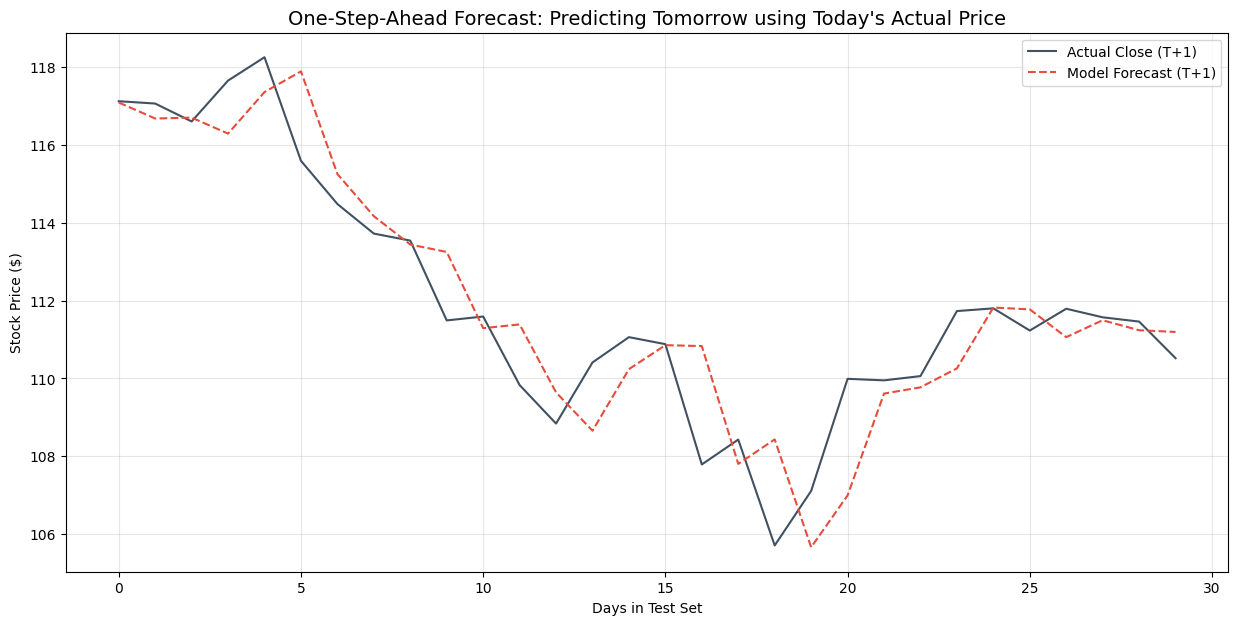

In [201]:
actual_prices_t_plus_1 = df['Close'].iloc[train_length + SEQ_LENGTH:].values

# 2. Get the "Anchor" prices (Actual Close at T)
# These are the prices the model 'knows' when it makes the prediction
# We take the prices from the day before each target day
anchor_prices_t = df['Close'].iloc[train_length + SEQ_LENGTH - 1 : -1].values

# 3. Calculate Predicted Price (T+1)
# Formula: Actual_Price(T) * (1 + Predicted_Return(T+1))
# Note: If you used standardization, preds_real is already back in % units
predicted_prices_t_plus_1 = anchor_prices_t * (1 + preds_real.flatten())

# 4. Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Actual Prices
plt.plot(actual_prices_t_plus_1, label='Actual Close (T+1)', color='#2c3e50', linewidth=1.5, alpha=0.9)

# Predicted Prices
plt.plot(predicted_prices_t_plus_1, label='Model Forecast (T+1)', color='#e74c3c', linestyle='--', linewidth=1.5)

plt.title('One-Step-Ahead Forecast: Predicting Tomorrow using Today\'s Actual Price', fontsize=14)
plt.xlabel('Days in Test Set')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [202]:
def get_trade_signal(lstm_prediction, sentiment_score, threshold=0.001):
    """
    Returns: 'BUY', 'SELL', or 'HOLD'
    Based on the agreement between LSTM return prediction and FinBERT sentiment.
    """
    # CASE 1: Strong Bullish Signal
    # LSTM predicts price UP AND Sentiment is Positive
    if lstm_prediction > threshold:
        return 'BUY'
    
    # CASE 2: Strong Bearish Signal
    # LSTM predicts price DOWN AND Sentiment is Negative
    elif lstm_prediction < -threshold:
        return 'SELL'
    
    # CASE 3: Divergence or Weak Signal
    # If they don't agree, or the move is too small, we stay out (Risk Management)
    else:
        return 'HOLD'

In [203]:
# 1. Extract Sentiment from the test data 
# (Assuming Sentiment is column index 1 in your scaled features)
SENTIMENT_IDX = 1
test_sentiments = X_test_np[:, -1, SENTIMENT_IDX]

# 2. Run the loop to generate signals
trade_signals = []
for i in range(len(preds_real)):
    pred_ret = preds_real[i][0]    # The predicted percentage return
    sent = test_sentiments[i]      # The FinBERT score for that day
    
    signal = get_trade_signal(pred_ret, sent)
    trade_signals.append(signal)

# 3. View the results
from collections import Counter
print("Trade Signal Distribution:", Counter(trade_signals))

Trade Signal Distribution: Counter({'SELL': 23, 'HOLD': 6, 'BUY': 1})


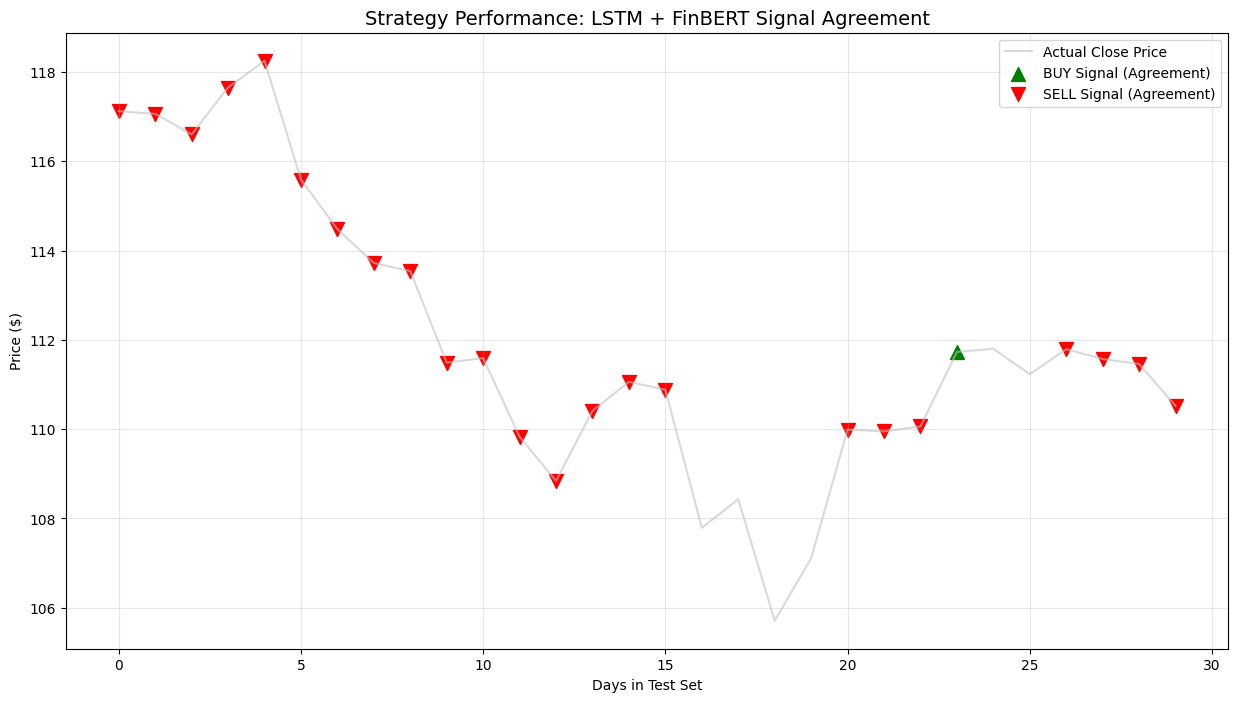

In [204]:
plt.figure(figsize=(15, 8))

# Plot the Actual Price for the test period
plt.plot(actual_prices_t_plus_1, label='Actual Close Price', color='silver', alpha=0.6)

# Separate indices for plotting
buys_idx = [i for i, s in enumerate(trade_signals) if s == 'BUY']
sells_idx = [i for i, s in enumerate(trade_signals) if s == 'SELL']

# Plot BUY signals (Green Up-Arrows)
plt.scatter(buys_idx, actual_prices_t_plus_1[buys_idx], 
            color='green', marker='^', s=100, label='BUY Signal (Agreement)')

# Plot SELL signals (Red Down-Arrows)
plt.scatter(sells_idx, actual_prices_t_plus_1[sells_idx], 
            color='red', marker='v', s=100, label='SELL Signal (Agreement)')

plt.title('Strategy Performance: LSTM + FinBERT Signal Agreement', fontsize=14)
plt.xlabel('Days in Test Set')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()